In [27]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [29]:
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

try:
  import torchinfo
  from torchinfo import summary
except:
  !pip install -q torchinfo
  import torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

In [30]:
def set_seeds(seed:int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [66]:
import os

root_dir = "data"

for root, dirs, files in os.walk(root_dir):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)



Root: data
Directories: ['DATASET_1']
Files: []
----------------------------------------
Root: data/DATASET_1
Directories: ['DATASET']
Files: []
----------------------------------------
Root: data/DATASET_1/DATASET
Directories: ['train', 'test']
Files: []
----------------------------------------
Root: data/DATASET_1/DATASET/train
Directories: ['MANGO', 'CUSTARD_APPLE', 'WATERMELON', 'APPLE', 'ORANGE']
Files: []
----------------------------------------
Root: data/DATASET_1/DATASET/train/MANGO
Directories: []
Files: ['Fresh Mangos (Dr_ Sebi Approved Alkaline Food).jpg', 'Mango Lassi [10 Minutes].jpg', 'Top 5 health benefits of mango.jpg', 'Mango isolated on background.jpg', 'download (5).jpg', 'download (4).jpg', 'What Fruits Can Dogs Eat_.jpg', 'download.jpg', 'How to Grow a Mango Tree.jpg', 'Mangifera indica.jpg', 'Premium Photo _ Mango with leaf isolated.jpg', 'The Fascinating Truth of the Alphonso Mango, Deemed _King of Mangoes_ - Pure Indian Foods Blog.jpg', 'La mangue, un parfum in

In [67]:
train_dir = "data/train"
test_dir = "data/test"


In [68]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:

    data_path = Path("data/")
    image_path = data_path / destination

    if not image_path.exists():
        print(f"[INFO] Did not find {image_path}, creating it...")
        image_path.mkdir(parents=True, exist_ok=True)

    target_file = Path(source).name
    zip_file_path = data_path / target_file

    if zip_file_path.exists():
        print(f"[INFO] {zip_file_path} already exists, skipping download.")
    else:
        try:
            print(f"[INFO] Downloading {target_file} from {source}...")
            response = requests.get(source)
            response.raise_for_status()

            with open(zip_file_path, "wb") as file:
                file.write(response.content)

            print(f"[INFO] Downloaded {target_file} successfully.")

        except requests.exceptions.RequestException as e:
            print(f"[ERROR] Failed to download the file: {e}")
            return None


    try:
        if zip_file_path.suffix == ".zip":
            print(f"[INFO] Unzipping {target_file}...")
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(image_path)
            print(f"[INFO] Unzipped data to {image_path}.")
        else:
            print("[ERROR] The downloaded file is not a valid zip file.")
            return None


        if remove_source:
            os.remove(zip_file_path)
            print(f"[INFO] Removed the zip file: {zip_file_path}")

    except zipfile.BadZipFile as e:
        print(f"[ERROR] Failed to unzip the file: {e}")
        return None

    return image_path

image_path = download_data(source="https://github.com/Shaheed-colab/Data/raw/refs/heads/main/DATASET_1.zip",
                           destination="DATASET_1")

if image_path:
    print(f"Data has been extracted to: {image_path}")
else:
    print("An error occurred during the download or extraction process.")


[INFO] Downloading DATASET_1.zip from https://github.com/Shaheed-colab/Data/raw/refs/heads/main/DATASET_1.zip...
[INFO] Downloaded DATASET_1.zip successfully.
[INFO] Unzipping DATASET_1.zip...
[INFO] Unzipped data to data/DATASET_1.
[INFO] Removed the zip file: data/DATASET_1.zip
Data has been extracted to: data/DATASET_1


In [69]:
# Setup directories
train_dir = image_path / "DATASET" / "train"
test_dir = image_path / "DATASET" / "test"


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7eb5e90e8640>,
 ['APPLE', 'CUSTARD_APPLE', 'MANGO', 'ORANGE', 'WATERMELON'])

In [70]:
train_dir = image_path / "DATASET" / "train"
test_dir = image_path / "DATASET" / "test"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

auto_transform = weights.transforms()

train_dataloader_auto, test_dataloader_auto, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transform,
    batch_size=32
)

train_dataloader_auto,test_dataloader_auto,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7eb49d1152d0>,
 ['APPLE', 'CUSTARD_APPLE', 'MANGO', 'ORANGE', 'WATERMELON'])

In [71]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():

  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)

  for param in model.features.parameters():
    param.requires_grad = False

  set_seeds()

  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)

  ).to(device)

  model.name = "effnetb0"
  print(model.name)
  return model

In [72]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [73]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from going_modular.going_modular.engine import train_step, test_step

def train(model : torch.nn.Module,
          loss_fn: torch.nn.CrossEntropyLoss(),
          optimizer : torch.optim.Optimizer,
          train_dataloader : torch.utils.data.DataLoader,
          test_dataloader : torch.utils.data.DataLoader,
          epochs: int,
          device = device):

  results = {"train_loss":[],
             "test_loss":[],
             "train_acc":[],
             "test_acc":[]}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader_auto,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader_auto,
                                    loss_fn = loss_fn,
                                    device = device)

    print(f"Epochs: {epoch+1} | Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test_acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)

    writer.add_scalars(main_tag = "Loss",
                      tag_scalar_dict = {"train_loss":train_loss,
                                        "test_loss":test_loss},
                      global_step = epoch)

    writer.add_scalars(main_tag = "Accuracy",
                      tag_scalar_dict = {"train_acc":train_acc,
                                        "test_acc":test_acc},
                      global_step = epoch)

    writer.add_graph(model = model,
                     input_to_model = torch.randn(32,3,224,224).to(device))

  writer.close()
  return results

In [74]:
def create_writer(experiment_name : str,
                  model_name : str,
                  extras : str = None):

  from datetime import datetime
  import os

  timestamp = datetime.now().strftime("%Y-%m-%d")

  if extras:
    log_dir = os.path.join("runs",timestamp,experiment_name,model_name,extras)
  else:
    log_dir = os.path.join("runs",timestamp,experiment_name,model_name)

  print(log_dir)
  return SummaryWriter(log_dir = log_dir)

In [75]:
example_writer = create_writer(experiment_name = "dataset_1",
                               model_name = "effnetb0",
                               extras = "5_epochs")

runs/2025-01-02/dataset_1/effnetb0/5_epochs


In [76]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from going_modular.going_modular.engine import train_step, test_step

def train(model : torch.nn.Module,
          loss_fn: torch.nn.CrossEntropyLoss(),
          optimizer : torch.optim.Optimizer,
          train_dataloader : torch.utils.data.DataLoader,
          test_dataloader : torch.utils.data.DataLoader,
          epochs: int,
          device = device,
          writer = torch.utils.tensorboard.writer.SummaryWriter):

  results = {"train_loss":[],
             "test_loss":[],
             "train_acc":[],
             "test_acc":[]}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader_auto,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader_auto,
                                    loss_fn = loss_fn,
                                    device = device)

    print(f"Epochs: {epoch+1} | Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test_acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)

    if writer:
      writer.add_scalars(main_tag = "Loss",
                        tag_scalar_dict = {"train_loss":train_loss,
                                          "test_loss":test_loss},
                        global_step = epoch)

      writer.add_scalars(main_tag = "Accuracy",
                        tag_scalar_dict = {"train_acc":train_acc,
                                          "test_acc":test_acc},
                        global_step = epoch)
      writer.close()
    else:
      pass
  return results

In [77]:
num_epochs = [5,10]
models = ["effnetb0"]
train_dataloaders = {"image_path":train_dataloader_auto}

In [78]:
%%time
from going_modular.going_modular.utils import save_model

set_seeds(seed=42)

experiment_number = 0

for dataloader_name,train_dataloader in train_dataloaders.items():

  for epochs in num_epochs:

    for model_name in models:

      experiment_number += 1
      print(f"Experiment number: {experiment_number}")
      print(f"Model name: {model_name}")
      print(f"Dataloader name: {dataloader_name}")
      print(f"Epochs: {epochs}")

      if model_name == "effnetb0":
        model = create_effnetb0()

      else:
        pass

      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(params = model.parameters(),
                                   lr = 0.01)

      train(model = model,
            train_dataloader = train_dataloader_auto,
            test_dataloader = test_dataloader_auto,
            loss_fn = loss_fn,
            optimizer = optimizer,
            epochs = epochs,
            device = device,
            writer = create_writer(experiment_name = dataloader_name,
                                   model_name = model_name,
                                   extras = f"epochs_{epochs}"))

      save_file_path = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model = model,
                 target_dir = "models",
                 model_name = save_file_path)
      print("-"*50 + "\n")

Experiment number: 1
Model name: effnetb0
Dataloader name: image_path
Epochs: 5
effnetb0
runs/2025-01-02/image_path/effnetb0/epochs_5


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | Train_loss: 1.1117 | Train_acc: 0.6136 | Test_loss: 0.3855 | Test_acc: 0.9375
Epochs: 2 | Train_loss: 0.2943 | Train_acc: 0.9045 | Test_loss: 0.1858 | Test_acc: 0.9688
Epochs: 3 | Train_loss: 0.1333 | Train_acc: 0.9597 | Test_loss: 0.1760 | Test_acc: 0.9453
Epochs: 4 | Train_loss: 0.0557 | Train_acc: 1.0000 | Test_loss: 0.2115 | Test_acc: 0.9219
Epochs: 5 | Train_loss: 0.0453 | Train_acc: 0.9847 | Test_loss: 0.2018 | Test_acc: 0.9297
[INFO] Saving model to: models/07_effnetb0_image_path_5_epochs.pth
--------------------------------------------------

Experiment number: 2
Model name: effnetb0
Dataloader name: image_path
Epochs: 10
effnetb0
runs/2025-01-02/image_path/effnetb0/epochs_10


  0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 1 | Train_loss: 1.1117 | Train_acc: 0.6136 | Test_loss: 0.3855 | Test_acc: 0.9375
Epochs: 2 | Train_loss: 0.2943 | Train_acc: 0.9045 | Test_loss: 0.1858 | Test_acc: 0.9688
Epochs: 3 | Train_loss: 0.1333 | Train_acc: 0.9597 | Test_loss: 0.1760 | Test_acc: 0.9453
Epochs: 4 | Train_loss: 0.0557 | Train_acc: 1.0000 | Test_loss: 0.2115 | Test_acc: 0.9219
Epochs: 5 | Train_loss: 0.0453 | Train_acc: 0.9847 | Test_loss: 0.2018 | Test_acc: 0.9297
Epochs: 6 | Train_loss: 0.0391 | Train_acc: 0.9938 | Test_loss: 0.1666 | Test_acc: 0.9453
Epochs: 7 | Train_loss: 0.0149 | Train_acc: 1.0000 | Test_loss: 0.1611 | Test_acc: 0.9453
Epochs: 8 | Train_loss: 0.0098 | Train_acc: 1.0000 | Test_loss: 0.1634 | Test_acc: 0.9453
Epochs: 9 | Train_loss: 0.0097 | Train_acc: 1.0000 | Test_loss: 0.1622 | Test_acc: 0.9531
Epochs: 10 | Train_loss: 0.0328 | Train_acc: 0.9938 | Test_loss: 0.1694 | Test_acc: 0.9531
[INFO] Saving model to: models/07_effnetb0_image_path_10_epochs.pth
-------------------------------

In [79]:
best_model_path = "models/07_effnetb0_image_path_5_epochs.pth" # Corrected the file name case
best_model = create_effnetb0()
best_model.load_state_dict(torch.load(best_model_path))

effnetb0


<ipython-input-79-ea709ca5decb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [80]:
from pathlib import Path

effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"Effnetb2 model size: {effnetb2_model_size} MB")

Effnetb2 model size: 15 MB


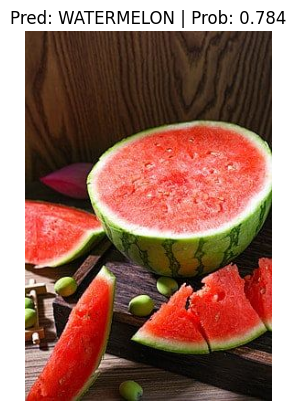

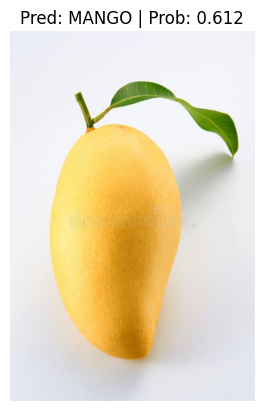

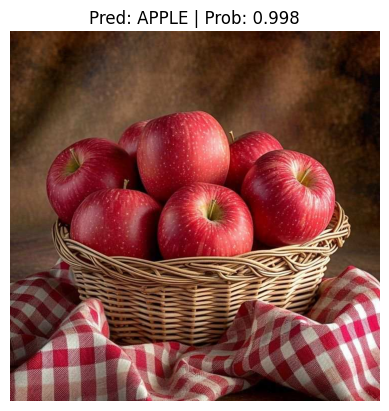

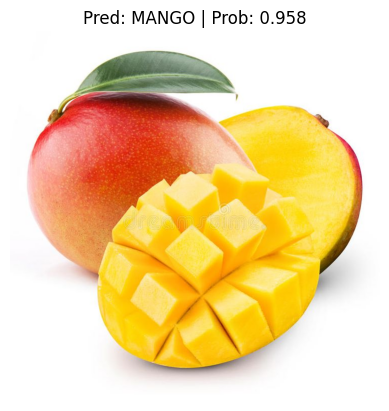

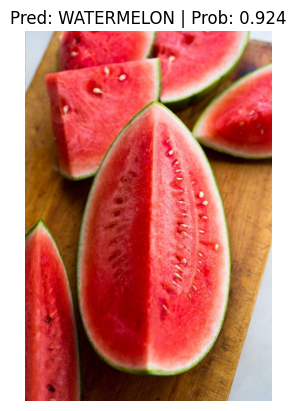

In [81]:
from going_modular.going_modular.predictions import pred_and_plot_image
import random

num_image_plots = 5
test_image_path_list = list(test_dir.glob("*/*.jpg"))
test_image_sample_path = random.sample(population = test_image_path_list,k=num_image_plots)

for image_path in test_image_sample_path:
  pred_and_plot_image(model = best_model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224,224))

WATERMELON.jpeg already exists and is valid.
WATERMELON.jpeg is a valid image.


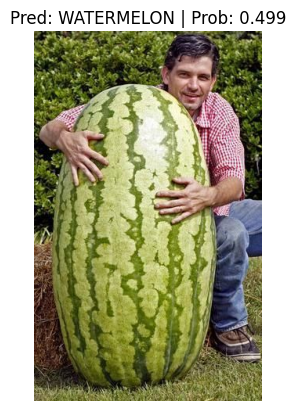

In [82]:
import requests
from pathlib import Path
from PIL import Image

url = "https://raw.githubusercontent.com/Shaheed-colab/Data/refs/heads/main/WATERMELON.jpg"
custom_image = Path("WATERMELON.jpeg")


if custom_image.is_file():
    try:

        Image.open(custom_image).verify()
        print(f"{custom_image.name} already exists and is valid.")
    except Exception:
        print(f"{custom_image.name} is invalid. Re-downloading...")
        custom_image.unlink()


if not custom_image.is_file():
    with open(custom_image, "wb") as f:
        response = requests.get(url)
        if response.status_code == 200:
            print(f"Downloading {custom_image.name}...")
            f.write(response.content)
            print(f"{custom_image.name} downloaded successfully.")
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")


try:
    img = Image.open(custom_image)
    img.verify()
    print(f"{custom_image.name} is a valid image.")
except Exception as e:
    print(f"Error: {e}. The downloaded file is not a valid image.")
    raise


pred_and_plot_image(model=model, image_path=custom_image, class_names=class_names)
